In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt 
import seaborn as sns
import os, sys
import re

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)



# Reading Data from CSV Files

In [2]:
df_books = pd.read_csv('Books.csv')
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [3]:
df_ratings = pd.read_csv('Ratings.csv')
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [4]:
df_users = pd.read_csv('Users.csv')
df_users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
valid_years = df_books['Year-Of-Publication'].astype(str).str.isnumeric()
books = df_books[valid_years]

In [6]:
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [7]:
valid_years = (books['Year-Of-Publication']>1980) & (books['Year-Of-Publication']<2023)
books = books[valid_years]

In [8]:
df_books = df_books[['ISBN', 'Book-Title', 'Book-Author']]

# Checking Null Values

In [9]:
df_books.isnull().sum()

ISBN           0
Book-Title     0
Book-Author    2
dtype: int64

In [10]:
df_ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [11]:
df_users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [13]:
df_users = df_users[['User-ID', 'Location']]

In [14]:
df_books.dropna(inplace=True)

In [15]:
df_books.isnull().sum()

ISBN           0
Book-Title     0
Book-Author    0
dtype: int64

# Exploratory Data Analysis

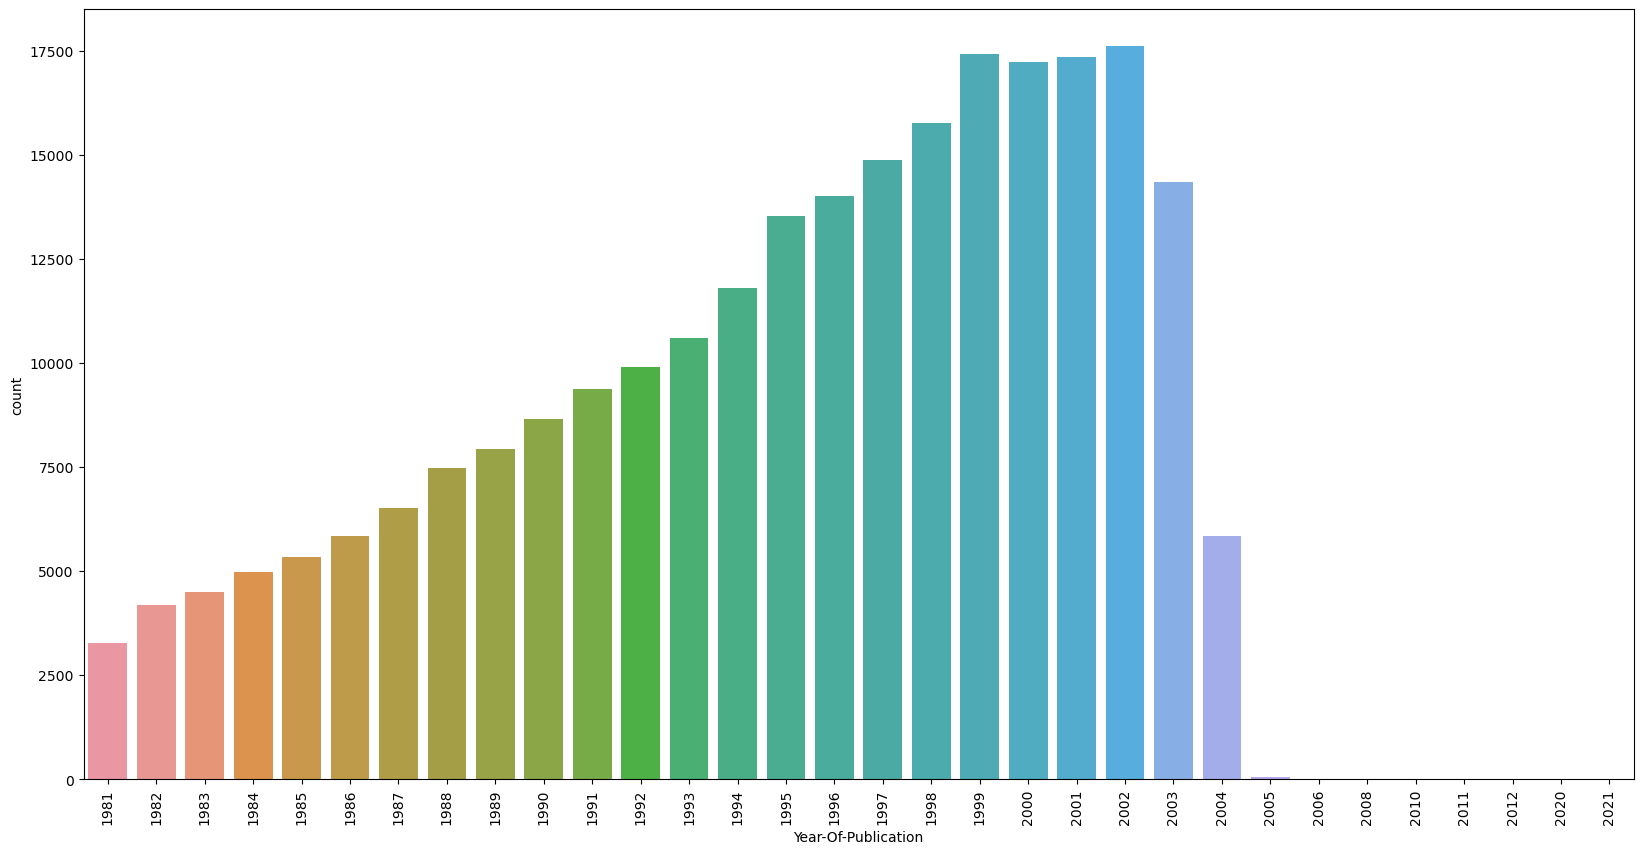

In [16]:
plt.figure(figsize=(20,10))
sns.countplot(x=books['Year-Of-Publication'])
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='Publisher'>

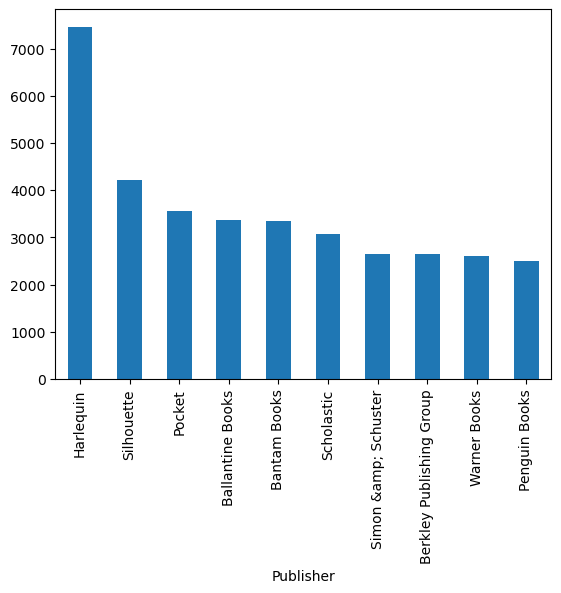

In [17]:
books['Publisher'].value_counts().head(10).plot(kind='bar')

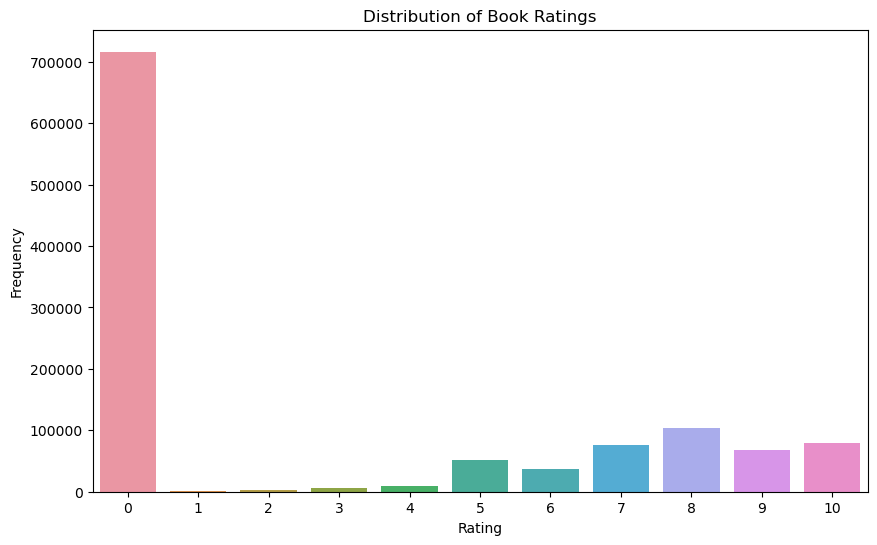

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_ratings, x='Book-Rating')
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [19]:
countries = []
cond = df_users['Location'].str.split(',')

for cont in cond:
    
    countries.append(cont[-1])
df_users['Country'] = countries
df_users.head()

,User-ID,Location,Country
0,1,"nyc, new york, usa",usa
1,2,"stockton, california, usa",usa
2,3,"moscow, yukon territory, russia",russia
3,4,"porto, v.n.gaia, portugal",portugal
4,5,"farnborough, hants, united kingdom",united kingdom


<Axes: xlabel='Country'>

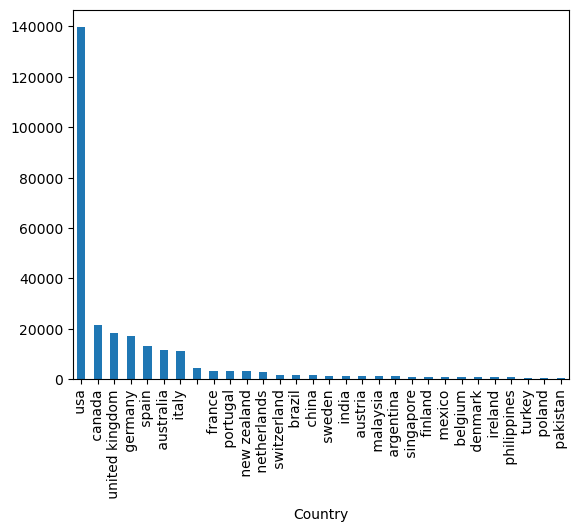

In [20]:
df_users['Country'].value_counts().head(30).plot(kind='bar')

# Data Preprocessing

In [21]:
df_books.shape

(271358, 3)

In [22]:
df_ratings.shape

(1149780, 3)

In [23]:
# Calculate the count of ratings given by each user and store it in the 'ratings' Series
ratings = df_ratings['User-ID'].value_counts()
# Sort the 'ratings' Series in descending order based on the counts of user IDs
ratings.sort_values(ascending=False).head()

User-ID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
Name: count, dtype: int64

In [24]:
len(ratings[ratings < 200])

104378

In [25]:
df_ratings['User-ID'].isin(ratings[ratings < 200].index).sum()

622224

In [26]:
df_ratings_rm = df_ratings[df_ratings['User-ID'].isin(ratings[ratings < 200].index)]
df_ratings_rm.shape

(622224, 3)

In [27]:
ratings = df_ratings['ISBN'].value_counts() 
ratings.sort_values(ascending=False).head()

ISBN
0971880107    2502
0316666343    1295
0385504209     883
0060928336     732
0312195516     723
Name: count, dtype: int64

In [28]:
len(ratings[ratings < 100])

339825

In [29]:
df_books['ISBN'].isin(ratings[ratings < 100].index).sum()

269422

In [30]:
df_ratings_rm = df_ratings_rm[
  ~df_ratings_rm['ISBN'].isin(ratings[ratings < 100].index)
]
df_ratings_rm.shape

(88680, 3)

In [31]:
books = ["Where the Heart Is (Oprah's Book Club (Paperback))",
        "I'll Be Seeing You",
        "The Weight of Water",
        "The Surgeon",
        "I Know This Much Is True"]

for book in books:
    print(df_ratings_rm['ISBN'].isin(df_books[df_books['Book-Title'] == book]['ISBN']).sum())

402
65
68
76
165


In [32]:
df_ratings_rm.head()

,User-ID,ISBN,Book-Rating
2,276727,0446520802,0
8,276744,038550120X,7
10,276746,0425115801,0
11,276746,0449006522,0
12,276746,0553561618,0


In [33]:
df_books.head()

,ISBN,Book-Title,Book-Author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [34]:
df = df_ratings_rm.pivot_table(index=['User-ID'],columns=['ISBN'],values='Book-Rating').fillna(0).T
df.head()

User-ID,9,14,16,26,39,42,44,51,67,75,...,278800,278807,278813,278819,278828,278832,278836,278843,278844,278854
ISBN,,,,,,,,,,,,,,,,,,,,,
002542730X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060008032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060096195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006016848X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060173289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0


In [35]:
df.index = df.join(df_books.set_index('ISBN'))['Book-Title']
df = df.sort_index()
df.head()

User-ID,9,14,16,26,39,42,44,51,67,75,...,278800,278807,278813,278819,278828,278832,278836,278843,278844,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
df.loc["The Queen of the Damned (Vampire Chronicles (Paperback))"][:5]

User-ID
9     0.0
14    0.0
16    0.0
26    0.0
39    0.0
Name: The Queen of the Damned (Vampire Chronicles (Paperback)), dtype: float64

# KNN Implementation

In [37]:
model = NearestNeighbors(metric='cosine')
model.fit(df.values)

NearestNeighbors(metric='cosine')

In [38]:
def get_recommendations(book_title=""):
    try:
        selected_book = df.loc[book_title]
    except KeyError:
        print(f"The book '{book_title}' does not exist.")
        return

    distances, indices = model.kneighbors([selected_book.values], n_neighbors=6)

    recommended_books_df = pd.DataFrame({
        'title': df.iloc[indices[0]].index.values,
        'distance': distances[0]
    })

    top_recommendations = recommended_books_df.sort_values(by='distance', ascending=True).head(5)

    return [book_title, top_recommendations.values]


In [39]:
books = get_recommendations("The Queen of the Damned (Vampire Chronicles (Paperback))")
print(books)

['The Queen of the Damned (Vampire Chronicles (Paperback))', array([['The Queen of the Damned (Vampire Chronicles (Paperback))', 0.0],
       ['The Tale of the Body Thief (Vampire Chronicles (Paperback))',
        0.5663108344339415],
       ['The Vampire Lestat (Vampire Chronicles, Book II)',
        0.617587945033209],
       ['Interview with the Vampire', 0.7145811575157306],
       ['Lasher: Lives of the Mayfair Witches (Lives of the Mayfair Witches)',
        0.8651937832505081]], dtype=object)]


In [40]:
books = get_recommendations("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

["Where the Heart Is (Oprah's Book Club (Paperback))", array([["Where the Heart Is (Oprah's Book Club (Paperback))", 0.0],
       ["Bridget Jones's Diary", 0.923513407573862],
       ['Drowning Ruth', 0.9303604433661193],
       ['That Camden Summer', 0.933592908329624],
       ["The Pilot's Wife : A Novel", 0.9401675842515036]], dtype=object)]


In [41]:
books = get_recommendations("A Bend in the Road")
print(books)

['A Bend in the Road', array([['A Bend in the Road', 0.0],
       ['A Walk to Remember', 0.9247340922628857],
       ["Suzanne's Diary for Nicholas", 0.9285482934478826],
       ['Message in a Bottle', 0.9380500653888402],
       ["Suzanne's Diary for Nicholas", 0.9381056894446229]], dtype=object)]


In [42]:
# Function to calculate cosine similarity
def cosine_similarity(vec_a, vec_b):
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    if norm_a == 0 or norm_b == 0:
        return 0  # Avoid division by zero; treat as no similarity
    return dot_product / (norm_a * norm_b)

In [43]:
# Function to find nearest neighbors
def find_nearest_neighbors(book_title, df, n_neighbors=6):
    try:
        selected_book = df.loc[book_title].values
    except KeyError:
        print(f"The book '{book_title}' does not exist in the dataset.")
        return

    similarities = []
    for other_title, row in df.iterrows():
        if other_title != book_title:  # Skip the selected book itself
            similarity = cosine_similarity(selected_book, row.values)
            similarities.append((other_title, similarity))

    # Sort by similarity (highest similarity first)
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    # Get the top n_neighbors
    top_neighbors = similarities[:n_neighbors]

    # Prepare a DataFrame of recommendations
    recommended_books_df = pd.DataFrame(top_neighbors, columns=["title", "similarity"])
    return recommended_books_df

In [44]:
# Example usage:
book_title = "A Bend in the Road"  # Replace with your desired book title
recommendations = find_nearest_neighbors(book_title, df, n_neighbors=6)
print(f"Recommendations for '{book_title}':")
print(recommendations)

Recommendations for 'A Bend in the Road':
                          title  similarity
0            A Walk to Remember    0.075266
1  Suzanne's Diary for Nicholas    0.071452
2           Message in a Bottle    0.061950
3  Suzanne's Diary for Nicholas    0.061894
4                    The Rescue    0.059456
5     Whirlwind (Tyler, Book 1)    0.058268


In [45]:
book_title = "The Queen of the Damned (Vampire Chronicles (Paperback))"  # Replace with your desired book title
recommendations = find_nearest_neighbors(book_title, df, n_neighbors=6)
print(f"Recommendations for '{book_title}':")
print(recommendations)

Recommendations for 'The Queen of the Damned (Vampire Chronicles (Paperback))':
                                                                 title  \
0          The Tale of the Body Thief (Vampire Chronicles (Paperback))   
1                     The Vampire Lestat (Vampire Chronicles, Book II)   
2                                           Interview with the Vampire   
3  Lasher: Lives of the Mayfair Witches (Lives of the Mayfair Witches)   
4                                       The Mummy or Ramses the Damned   
5                     The Witching Hour (Lives of the Mayfair Witches)   

   similarity  
0    0.433689  
1    0.382412  
2    0.285419  
3    0.134806  
4    0.118091  
5    0.087309  


In [46]:
book_title = "Where the Heart Is (Oprah's Book Club (Paperback))"  # Replace with your desired book title
recommendations = find_nearest_neighbors(book_title, df, n_neighbors=6)
print(f"Recommendations for '{book_title}':")
print(recommendations)

Recommendations for 'Where the Heart Is (Oprah's Book Club (Paperback))':
                                   title  similarity
0                  Bridget Jones's Diary    0.076487
1                          Drowning Ruth    0.069640
2                     That Camden Summer    0.066407
3             The Pilot's Wife : A Novel    0.059832
4  She's Come Undone (Oprah's Book Club)    0.059580
5                  The Rapture of Canaan    0.058314
